In [3]:
from src.data.config_reader import *
from src.data.path_finder import *
from src.data.database_configurations import *

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import mlflow
from pycaret.classification import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12,7)

In [2]:
# Creating an SQLite database into which we can consolidate the seperate csv files as SQL tables
initiate_database()

Target db exists  moving on to table building operation...


In [4]:
# Access database
conn = connect_db()

## Getting to know the data

### Product table

In [4]:
df = pd.read_sql("SELECT * FROM df_product", conn)
print(df.shape)

(1441753, 7)


In [5]:
# Gender and Age variables have a great deal of missing values
(df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False) # P.S: values are in percent.

age                  21.585
gender               15.369
title                 0.041
contentid             0.000
currentbugroupname    0.000
brandid               0.000
categoryname          0.000
dtype: float64

#### Brand Distribution

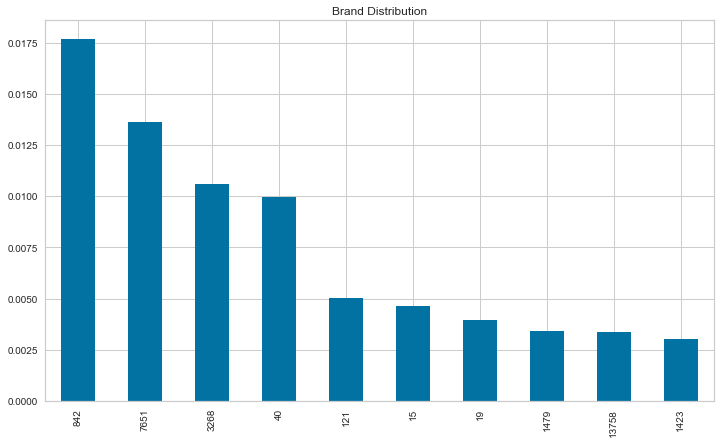

In [6]:
df.brandid.value_counts(normalize=True, ascending=False).head(10).plot(kind='bar', title="Brand Distribution");

__Interesting insight:__ Top 4 Brands owns around %5 percent of the products in the marketplace

#### Gender Distribution

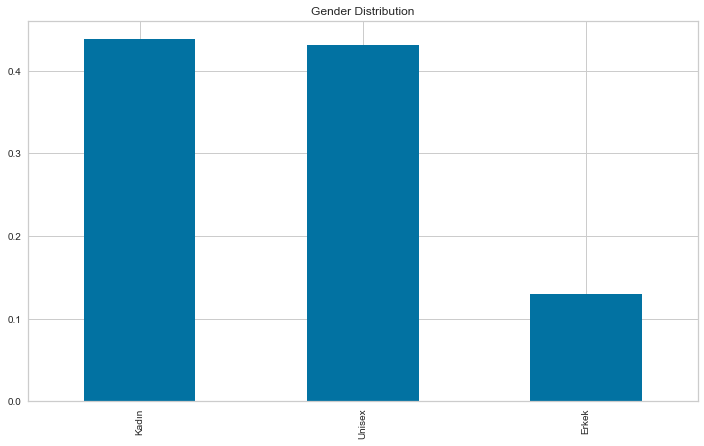

In [7]:
# Seems like it's the women's world!
# Gender will be an important feature in the model apparently
df.gender.value_counts(normalize=True, ascending=False).plot(kind='bar', title="Gender Distribution");

### Demographics table

#### Gender Distribution

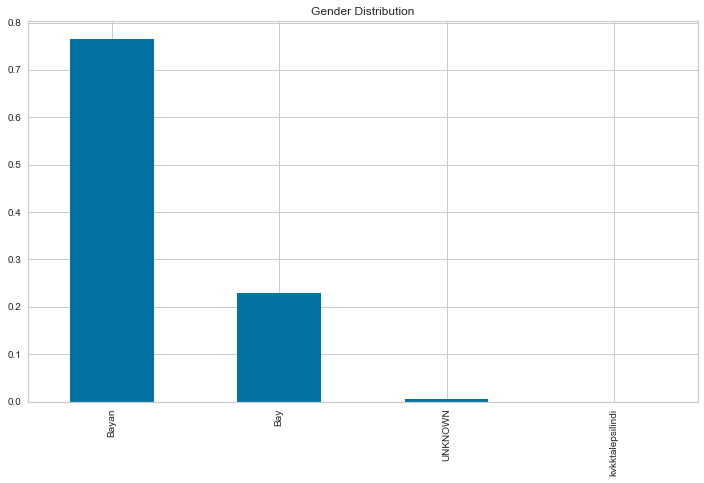

In [8]:
df = pd.read_sql("SELECT * FROM df_demo", conn)
df.gender.value_counts(normalize=True, ascending=False).plot(kind='bar', title="Gender Distribution");

Demand meets supply here. Gender will certainly be of immense importance!

--------------
--------------

## Data Manipulation and Cleaning

The aim is to transform the original train dataset into a binary classification suitable format. The original data consists only of the purchases __made__ by the users. In other words the data does not contain label "0". 

To overcome this problem, I have applied some manipulation techniques to join non-present **__currentbugroupname__** values to the original data; since non-presence indicates that the user did not purchase any thing with the given **__currentbugroupname__** label.

In [9]:
# Here we start manipulating the train dataset
df_target_train = pd.read_sql("SELECT * FROM df_target_train", conn)
df_target_train["userid"] = df_target_train["userid"].astype(str)
df_target_train.sort_values("userid", inplace=True)
df_target_train.dropna(subset=["currentbugroupname"], inplace=True)

In [10]:
# We now instantiate an empty DataFrame that will end up containing all the currentbugroupname combinations for each user
df_target_train_cleaned = pd.DataFrame()

# Storing unique userids and groupnames in order to create all "userid - currentbugroupname" scenarios
df_target_train_cleaned["userid"] = df_target_train["userid"].sort_values().unique()
df_target_train_cleaned["groupname"] = [df_target_train["currentbugroupname"].sort_values().unique().tolist()] * df_target_train_cleaned["userid"].nunique()
df_target_train_cleaned = df_target_train_cleaned.explode("groupname").sort_values("userid").reset_index(drop=True)
df_target_train_cleaned.sort_values(["userid"], inplace=True)
df_target_train_cleaned.reset_index(drop=True, inplace=True)

In [11]:
groupname_list = df_target_train["currentbugroupname"].sort_values().unique().tolist()

In [12]:
# After creating a synthetic train dataset we can gather the purchase information from the original data
# and use the information to label the corresponding rows as "1"
merged = pd.merge(df_target_train, df_target_train_cleaned, how='left', on=['userid'])
merged.sort_values("userid", inplace=True)

# Necessary operations to align the group names and purchases
# (i.e, if the user purchased an FMCG product the label will be "1")
merged["bol"] = merged.groupby(["userid", "currentbugroupname"]).currentbugroupname.transform(lambda x: x.duplicated())
merged["currentbugroupname"] = merged.apply(lambda x: np.nan if x["bol"] else x["currentbugroupname"], axis=1)
merged.reset_index(drop=True, inplace=True)
merged["y"] = merged.groupby("userid").apply(lambda x: x["groupname"].isin(x["currentbugroupname"])).reset_index()["groupname"].replace({True:1, False:0})

merged.drop(columns=["bol", "currentbugroupname"], inplace=True)
merged.drop_duplicates(subset=["userid", "groupname"], inplace=True)
merged.rename(columns={"groupname": "currentbugroupname"}, inplace=True)

In [13]:
# Notice that all 12 distinct groupnames are labeled accordingly for each user
merged.head(14)

,userid,currentbugroupname,y
0,10000270,Aksesuar & Saat & Gözlük,0
1,10000270,FMCG,1
2,10000270,Private Label,0
3,10000270,Kozmetik,0
4,10000270,GAS,0
5,10000270,Digital Goods,0
6,10000270,Mobilya,0
7,10000270,Elektronik,0
8,10000270,Branded Tekstil,0
9,10000270,Ayakkabı & Çanta,0


In [14]:
# Upon obtaining a suitable dataframe, we can start connecting other tables in the db
# To this end we will create a dictionary that will provide a valid currentbugroupname for each content in the database
df_products = pd.read_sql("SELECT contentid, currentbugroupname FROM df_product", conn)
df_products.head()

,contentid,currentbugroupname
0,40100964,Ayakkabı & Çanta
1,40427970,Branded Tekstil
2,41026644,FMCG
3,41227029,Branded Tekstil
4,40770080,Ev


In [15]:
products_dict = df_products.set_index("contentid").to_dict("dict")["currentbugroupname"]

In [16]:
# Now we can use this dictionary to create a currentbugroupname column in each table that contains contentid
m = merged.copy()

# We will use a for loop to iterate over the tables to link the contents to the group names and join the tables each other
for table in ["df_demo", "df_basket", "df_visit", "df_trx", "df_fav"]:
    df_table = pd.read_sql(f"SELECT * FROM {table}", conn)
    df_table["userid"] = df_table["userid"].astype(str)
    
    # Demographical data does not contain content, thus it will be handled with an else statement
    if table != "df_demo":
        df_table["currentbugroupname"] = df_table["contentid"].map(products_dict)
        df_table = df_table.groupby(["userid", "currentbugroupname"]).sum().reset_index().drop(columns=["contentid"])
        column_names = [f'{k}_{table.replace("df_", "")}' if k not in ["userid", "currentbugroupname"] else k for k in df_table.columns]
        df_table.columns = column_names
        m = m.merge(df_table, on=["userid", "currentbugroupname"], how="left")      
    else:
        df_table["gender"].str.replace("kvkktalepsilindi", "UNKNOWN")
        df_table["age"] = np.where(df_table["age"]>100, np.nan, df_table["age"])
        df_table["age"] = np.where(df_table["age"]<5, np.nan, df_table["age"])
        m = m.merge(df_table, on=["userid"], how="left")

In [17]:
# Table "m" seems more eligible for the task at hand now!
m.head()

,userid,currentbugroupname,y,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,price_trx,fav_count_fav
0,10000270,Aksesuar & Saat & Gözlük,0,Bayan,39.000,85,NaN,NaN,NaN,NaN,NaN
1,10000270,FMCG,1,Bayan,39.000,85,NaN,33.000,NaN,NaN,NaN
2,10000270,Private Label,0,Bayan,39.000,85,NaN,4.000,NaN,NaN,NaN
3,10000270,Kozmetik,0,Bayan,39.000,85,NaN,6.000,NaN,NaN,NaN
4,10000270,GAS,0,Bayan,39.000,85,NaN,1.000,NaN,NaN,NaN


In [18]:
# Imputing nan values
na_columns = m.select_dtypes(include=np.number).drop(columns=["age", "y"])
na_columns.fillna(0, inplace=True)
m.loc[:, na_columns.columns] = na_columns
m

,userid,currentbugroupname,y,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,price_trx,fav_count_fav
0,10000270,Aksesuar & Saat & Gözlük,0,Bayan,39.000,85,0.000,0.000,0.000,0.000,0.000
1,10000270,FMCG,1,Bayan,39.000,85,0.000,33.000,0.000,0.000,0.000
2,10000270,Private Label,0,Bayan,39.000,85,0.000,4.000,0.000,0.000,0.000
3,10000270,Kozmetik,0,Bayan,39.000,85,0.000,6.000,0.000,0.000,0.000
4,10000270,GAS,0,Bayan,39.000,85,0.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
216595,9998688,Kozmetik,0,Bayan,31.000,85,0.000,4.000,0.000,0.000,1.000
216596,9998688,Mobilya,0,Bayan,31.000,85,0.000,5.000,0.000,0.000,0.000
216597,9998688,GAS,0,Bayan,31.000,85,0.000,13.000,0.000,0.000,3.000
216598,9998688,Private Label,1,Bayan,31.000,85,0.000,351.000,1.000,48.990,35.000


In [19]:
m.isnull().sum()

userid                           0
currentbugroupname               0
y                                0
gender                           0
age                         121728
tenure                           0
addtobasket_count_basket         0
productdetailcount_visit         0
quantity_trx                     0
price_trx                        0
fav_count_fav                    0
dtype: int64

In [20]:
m.to_csv("input_data/processed/clean_data.csv", index=False)

## Feature Generation

Search terms table carries a great deal of potential to encrich the dataset. We first need to use text vectorization techniques to create a structural data. To this end we will use __Term Frequency–Inverse Document Frequency (TFIDF)__. Simply put, we will try to match the search terms with the content category names so that we can see if a searching event can be linked to a content in the df_products table.

Experimenting with other techniques such as __Siamese Neural Nets__ would worth trying

In [4]:
# Get category names from the product table
df_cats = pd.read_sql("SELECT categoryname FROM df_product", conn)
df_cats = df_cats.dropna().drop_duplicates()
df_cats = df_cats.replace("[^\w ]", "", regex=True)
print(df_cats.shape)

(2529, 1)


In [5]:
# Get search terms
df_search = pd.read_sql("SELECT * FROM df_search_term", conn)
df_search = df_search.dropna().drop_duplicates(subset=["search_term"]).query("search_term != 'tum urunler'")
df_search = df_search.replace("[^\w ]", "", regex=True)
df_search.shape

(373425, 3)

In [6]:
# Initialize a TFIDF vectorizer to create structural text data
vectorizer_ntf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3))

# Transform both Vector 1 (Category Names) and Vector 2 (Search Terms)
X_ntf_cats = vectorizer_ntf.fit_transform(df_cats["categoryname"].to_numpy())
X_ntf_search = vectorizer_ntf.transform(df_search["search_term"].to_numpy())

In [7]:
# Calculate cosine similarities of each pair
X_ntf = cosine_similarity(X_ntf_search, X_ntf_cats)
X_ntf.shape

(373425, 2529)

In [8]:
# The data occupies a huge area in the memory so we try to get rid of the unsignificant rows/columns with 0 score
df_similarity = pd.concat([pd.DataFrame(X_ntf,index=df_search["search_term"], columns=df_cats["categoryname"])],axis=1).replace(0, np.nan)
df_similarity.dropna(how="all", inplace=True)
df_similarity.dropna(how="all", inplace=True, axis=1)
df_similarity.shape

(208791, 2487)

In [9]:
# En example of a matching pair (e.g., "Kazak" and "ananaslı kazak")
a = "ananaslı kazak"
df_similarity.loc[a].sort_values(ascending=False).head()

categoryname
Kazak               1.000
Tesettür Kazak      0.608
Büyük Beden Kazak   0.444
Klasik Ayakkabı       NaN
Pantolon              NaN
Name: ananaslı kazak, dtype: float64

In [10]:
# We now make some changes in the dataframe to fit it into a dictionary format for later use
melted = df_similarity.reset_index().melt(id_vars="search_term", value_vars=[k for k in df_similarity.columns if k != "search_term"]).dropna(subset=["value"])
melted = melted.query("value >= 0.15").sort_values(["search_term", "value"], ascending=False)
melted["rank"] = 1
melted["num"] = melted.groupby("search_term")["rank"].transform(np.cumsum)
melted = melted.query("num < 4")[["search_term", "categoryname"]]
melted.head()

,search_term,categoryname
255824352,əl kol diz dirsək ağrıları,Kol Düğmesi
162034741,űstű dolap alti cekmece,Dolap ve Gardrop
59291071,şşn musluk,Batarya Musluk
94844666,şırınga model kalem,Model Araçlar
327437840,şırınga model kalem,Kalem Setleri


In [11]:
# Since we see that some of the terms are matched with some category names, this can lead us to connecting search terms
# to product table which eventually be useful to create a new feature in the target table
search_term_dict = melted.set_index("search_term").to_dict("dict")["categoryname"]
search_term_dict["şık yüz maskesi"]

'Yüz Temizleyici'

In [12]:
# Search terms are replaced with category names to create implicit representations of search terms
df_search["target_categoryname"] = df_search["search_term"].map(search_term_dict)

In [13]:
df_products = pd.read_sql("SELECT categoryname, currentbugroupname FROM df_product", conn)
df_products.head()

,categoryname,currentbugroupname
0,Klasik Ayakkabı,Ayakkabı & Çanta
1,Pantolon,Branded Tekstil
2,Akvaryum Balık Yemleri,FMCG
3,Külot,Branded Tekstil
4,Tabak,Ev


In [14]:
products_dict = df_products.set_index("categoryname").to_dict("dict")["currentbugroupname"]
products_dict["Pantolon"]

'Branded Tekstil'

In [15]:
# Now we can match implicit representations of search terms with the product table
df_search["currentbugroupname"] = df_search["target_categoryname"].map(products_dict)

In [16]:
# Aggregating the values by summation
df_final = df_search.groupby(["userid", "currentbugroupname"], as_index=False).agg({"partition_date": "count"}).rename(columns={"partition_date": "search_count"})
df_final["userid"] = df_final["userid"].astype(str)

In [17]:
df_final.head()

,userid,currentbugroupname,search_count
0,12810,Aksesuar & Saat & Gözlük,1
1,12810,GAS,2
2,12810,Kozmetik,1
3,15148,Ev,1
4,23198,FMCG,1


In [18]:
# Read the main (train dataset) and merge it with the newly created dataframe
df = pd.read_csv("input_data/processed/clean_data.csv")
df["userid"] = df["userid"].astype(str)
df = df.merge(df_final, on=["userid", "currentbugroupname"], how="left")

### Zen Score
This is a crafted feature that aims to catch a non-linear interaction. In the simplest form, this score indicates if there is a specific bugroupname or bugroupnames that the customer keeps viewing or else is he/she actively wandering around the platform without focusing on a product within a day. This will simply tell the extent of which the user focused on specific kinds of products.

__The formula is as follows:__

$(1 - views \div total)^2$
---
$\text{where views = Number of unique products viewed, total = Number of total views made}$
---
<br>


A number close to 1 means a Zen day (e.g., looking for a specific product) and a number closer to 0 means the user does not look for something specific.

Upon calculating the Zen Scores of each user in a given day, now it's time to calculate the number of Zen days and determine if the target currentbugroupname value is in the visit history of the user. 

In [19]:
# Get the product viewing data with 'currentbugroupname' variable joined
df_visits = pd.read_sql("""
WITH cte AS
    (
    SELECT df_visit.*, df_product.currentbugroupname FROM df_visit
    LEFT JOIN df_product ON df_visit.contentid = df_product.contentid
    )

SELECT * FROM cte WHERE currentbugroupname IS NOT NULL
""", conn)

df_visits["partition_date"] = pd.to_datetime(df_visits["partition_date"])
df_visits.set_index("partition_date", inplace=True)

# Groupby using 'userid' and 'partition_date' variables calculate total numbers of views and 
# number of unique 'currentbugroupnames' in addition to corresponding group names each day
df_visits = df_visits.groupby(["userid",pd.Grouper(freq="D")]).agg(
    {
        "productdetailcount": "sum", 
        "currentbugroupname": ["nunique", ("unique_groups", lambda x: list(set(x))[:5])]
    }
)

# Flattening column levels
df_visits.columns =  ["_".join(col_name).rstrip('_') for col_name in df_visits.columns.to_flat_index()]

# Finally calculate the zen ratio
df_visits["zen_ratio"] = df_visits.apply(lambda x: (1 - x["currentbugroupname_nunique"] / x["productdetailcount_sum"]) ** 2, axis=1)
df_visits.head()

productdetailcount_sum  currentbugroupname_nunique  \
userid partition_date                                                       
12810  2020-10-03                          26                           3   
       2020-10-04                           6                           4   
       2020-10-05                          40                           5   
       2020-10-06                         266                          10   
       2020-10-07                           1                           1   

                                        currentbugroupname_unique_groups  \
userid partition_date                                                      
12810  2020-10-03      [Ayakkabı & Çanta, Private Label, Branded Teks...   
       2020-10-04             [Ev, Ayakkabı & Çanta, Private Label, GAS]   
       2020-10-05      [Ayakkabı & Çanta, GM, GAS, Branded Tekstil, P...   
       2020-10-06          [Mobilya, Ayakkabı & Çanta, GM, Kozmetik, Ev]   
       2020-10-07                                      [Branded Tekstil]   

                       zen_ratio  
userid partition_date             
12810  2020-10-03          0.783  
       2020-10-04          0.111  
       2020-10-05          0.766  
       2020-10-06          0.926  
       2020-10-07          0.000

In [20]:
### Now, we will calculate mean zen_ratio for each user-currentbugroupname pairs
# 1- First we need to "explode" the list of unique currentbugroupname names across rows to obtain user-groupname pairs
df_visits_mean = df_visits.explode("currentbugroupname_unique_groups")
df_visits_mean.head()

productdetailcount_sum  currentbugroupname_nunique  \
userid partition_date                                                       
12810  2020-10-03                          26                           3   
       2020-10-03                          26                           3   
       2020-10-03                          26                           3   
       2020-10-04                           6                           4   
       2020-10-04                           6                           4   

                      currentbugroupname_unique_groups  zen_ratio  
userid partition_date                                              
12810  2020-10-03                     Ayakkabı & Çanta      0.783  
       2020-10-03                        Private Label      0.783  
       2020-10-03                      Branded Tekstil      0.783  
       2020-10-04                                   Ev      0.111  
       2020-10-04                     Ayakkabı & Çanta      0.111

In [21]:
# 2- Using pivot_table calculate the corresponding zen ratio mean for each pairs
df_visits_mean = df_visits_mean.pivot_table(index="userid", columns="currentbugroupname_unique_groups", values="zen_ratio", aggfunc="mean").reset_index()
df_visits_mean.head()

currentbugroupname_unique_groups,userid,Aksesuar & Saat & Gözlük,Ayakkabı & Çanta,Branded Tekstil,Digital Goods,Elektronik,Ev,FMCG,GAS,GM,Kozmetik,Mobilya,Private Label,UNKNOWN
0,12810,0.460,0.678,0.712,NaN,NaN,0.668,0.521,0.731,0.753,0.847,0.770,0.701,NaN
1,14302,NaN,0.900,NaN,NaN,0.450,NaN,NaN,0.444,0.000,NaN,NaN,NaN,NaN
2,15148,0.379,0.802,0.754,NaN,0.476,0.459,0.670,0.664,0.791,0.623,0.591,0.467,NaN
3,23198,0.574,0.125,0.557,NaN,0.360,0.584,0.526,0.427,0.548,0.481,NaN,0.508,NaN
4,25005,0.396,0.727,0.681,NaN,NaN,0.603,0.716,0.766,0.700,0.538,0.700,0.483,NaN


In [22]:
# 3- Convert the table from wide format to long format
df_visits_mean = df_visits_mean.melt(id_vars=["userid"], value_vars=[k for k in df_visits_mean.columns if k != "userid"], value_name="zen_mean").dropna(subset=["zen_mean"])
df_visits_mean["userid"] = df_visits_mean["userid"].astype(str)
df_visits_mean.head()

,userid,currentbugroupname_unique_groups,zen_mean
0,12810,Aksesuar & Saat & Gözlük,0.460
2,15148,Aksesuar & Saat & Gözlük,0.379
3,23198,Aksesuar & Saat & Gözlük,0.574
4,25005,Aksesuar & Saat & Gözlük,0.396
6,28742,Aksesuar & Saat & Gözlük,0.759


In [25]:
# 4- Repeat the same procedure for the number of zen days count
df_visits_count = df_visits.explode("currentbugroupname_unique_groups").pivot_table(index="userid", columns="currentbugroupname_unique_groups", values="zen_ratio", aggfunc="count").reset_index()
df_visits_count = df_visits_count.melt(id_vars=["userid"], value_vars=[k for k in df_visits_count.columns if k != "userid"], value_name="zen_count").dropna(subset=["zen_count"])
df_visits_count["userid"] = df_visits_count["userid"].astype(str)

In [26]:
# 5- Finally merge both tables with the main table
df = df.merge(df_visits_mean, left_on=["userid","currentbugroupname"] ,right_on=["userid", "currentbugroupname_unique_groups"], how="left")
df.drop(columns=["currentbugroupname_unique_groups"], inplace=True)
df["zen_mean"] = df["zen_mean"].fillna(0)

df = df.merge(df_visits_count, left_on=["userid","currentbugroupname"] ,right_on=["userid", "currentbugroupname_unique_groups"], how="left")
df.drop(columns=["currentbugroupname_unique_groups"], inplace=True)
df["zen_count"] = df["zen_count"].fillna(0)
df.head()

,userid,currentbugroupname,y,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,price_trx,fav_count_fav,search_count,zen_mean,zen_count
0,10000270,Aksesuar & Saat & Gözlük,0,Bayan,39.000,85,0.000,0.000,0.000,0.000,0.000,NaN,0.000,0.000
1,10000270,FMCG,1,Bayan,39.000,85,0.000,33.000,0.000,0.000,0.000,NaN,0.562,7.000
2,10000270,Private Label,0,Bayan,39.000,85,0.000,4.000,0.000,0.000,0.000,NaN,0.503,2.000
3,10000270,Kozmetik,0,Bayan,39.000,85,0.000,6.000,0.000,0.000,0.000,NaN,0.350,3.000
4,10000270,GAS,0,Bayan,39.000,85,0.000,1.000,0.000,0.000,0.000,NaN,0.000,1.000


In [ ]:
df.to_csv("input_data/processed/processed_data.csv", index=False)

# Model Training

In [1]:
from src.data.config_reader import *
from src.data.path_finder import *
from src.data.database_configurations import *

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

import mlflow
from pycaret.classification import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12,7)

# Access database
conn = connect_db()

In [2]:
# Read the cleaned and feature engineered train data
df = pd.read_csv("input_data/processed/processed_data.csv")
df.drop(columns=["price_trx"], inplace=True)
df.loc[:, "tenure":] = df.loc[:, "tenure":].fillna(0)
df["userid"] = df["userid"].astype(str)

In [11]:
# Read the cleaned and feature engineered test data
df_test = pd.read_sql("SELECT * FROM df_test_final", conn).query("gender == 'Bay' or gender == 'Bayan'")
df_test.loc[:, "tenure":] = df_test.loc[:, "tenure":].fillna(0)
df_test["userid"] = df_test["userid"].astype(str)

In [ ]:
df.isnull().sum()

In [105]:
df_test["age"] = z[0]

In [32]:
df["age"] = z[0]

In [117]:
df.head()

,currentbugroupname,y,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count
0,Aksesuar & Saat & Gözlük,0,Bayan,39.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,FMCG,1,Bayan,39.000,85,0.000,33.000,0.000,0.000,0.000,0.562,7.000
2,Private Label,0,Bayan,39.000,85,0.000,4.000,0.000,0.000,0.000,0.503,2.000
3,Kozmetik,0,Bayan,39.000,85,0.000,6.000,0.000,0.000,0.000,0.350,3.000
4,GAS,0,Bayan,39.000,85,0.000,1.000,0.000,0.000,0.000,0.000,1.000


In [46]:
df_test.head()

,userid,currentbugroupname,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count
0,10000970,Aksesuar & Saat & Gözlük,Bayan,50.000,85,0.000,336.000,2.000,45.000,3.000,0.761,14.000
1,10000970,Kozmetik,Bayan,50.000,85,0.000,138.000,3.000,9.000,0.000,0.801,5.000
2,10000970,Mobilya,Bayan,50.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,10000970,Private Label,Bayan,50.000,85,0.000,19.000,0.000,2.000,0.000,0.768,5.000
4,10000970,FMCG,Bayan,50.000,85,0.000,4.000,0.000,0.000,0.000,0.760,2.000


In [30]:
df_test.isnull().sum()

userid                           0
currentbugroupname               0
gender                           0
age                         140304
tenure                           0
addtobasket_count_basket         0
productdetailcount_visit         0
quantity_trx                     0
fav_count_fav                    0
search_count                     0
zen_mean                         0
zen_count                        0
dtype: int64

In [118]:
df.isnull().sum()

currentbugroupname          0
y                           0
gender                      0
age                         0
tenure                      0
addtobasket_count_basket    0
productdetailcount_visit    0
quantity_trx                0
fav_count_fav               0
search_count                0
zen_mean                    0
zen_count                   0
dtype: int64

In [49]:
df_test.drop(columns=["userid"], inplace=True)
df.drop(columns=["userid"], inplace=True)
display(df_test)
display(df)

,currentbugroupname,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count
0,Aksesuar & Saat & Gözlük,Bayan,50.000,85,0.000,336.000,2.000,45.000,3.000,0.761,14.000
1,Kozmetik,Bayan,50.000,85,0.000,138.000,3.000,9.000,0.000,0.801,5.000
2,Mobilya,Bayan,50.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,Private Label,Bayan,50.000,85,0.000,19.000,0.000,2.000,0.000,0.768,5.000
4,FMCG,Bayan,50.000,85,0.000,4.000,0.000,0.000,0.000,0.760,2.000
...,...,...,...,...,...,...,...,...,...,...,...
244831,GAS,Bayan,24.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000
244832,Digital Goods,Bayan,24.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000
244833,Branded Tekstil,Bayan,24.000,85,0.000,233.000,0.000,0.000,2.000,0.772,12.000
244834,FMCG,Bayan,24.000,85,0.000,17.000,0.000,0.000,0.000,0.515,5.000


,currentbugroupname,y,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count,test
0,Aksesuar & Saat & Gözlük,0,Bayan,39.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000,50.000
1,FMCG,1,Bayan,39.000,85,0.000,33.000,0.000,0.000,0.000,0.562,7.000,50.000
2,Private Label,0,Bayan,39.000,85,0.000,4.000,0.000,0.000,0.000,0.503,2.000,50.000
3,Kozmetik,0,Bayan,39.000,85,0.000,6.000,0.000,0.000,0.000,0.350,3.000,50.000
4,GAS,0,Bayan,39.000,85,0.000,1.000,0.000,0.000,0.000,0.000,1.000,50.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216595,Kozmetik,0,Bayan,31.000,85,0.000,4.000,0.000,1.000,0.000,0.379,2.000,32.000
216596,Mobilya,0,Bayan,31.000,85,0.000,5.000,0.000,0.000,0.000,0.489,2.000,32.000
216597,GAS,0,Bayan,31.000,85,0.000,13.000,0.000,3.000,0.000,0.596,7.000,32.000
216598,Private Label,1,Bayan,31.000,85,0.000,351.000,1.000,35.000,0.000,0.640,26.000,32.000


In [17]:
#df.to_sql("df_train_imputated", conn, if_exists="replace", index=False)

In [4]:
df = pd.read_sql("SELECT * FROM df_train_imputated", conn).query("gender == 'Bay' or gender == 'Bayan'")

In [94]:
df.head()

,userid,currentbugroupname,y,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count
0,10000270,Aksesuar & Saat & Gözlük,0,Bayan,39.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,10000270,FMCG,1,Bayan,39.000,85,0.000,33.000,0.000,0.000,0.000,0.562,7.000
2,10000270,Private Label,0,Bayan,39.000,85,0.000,4.000,0.000,0.000,0.000,0.503,2.000
3,10000270,Kozmetik,0,Bayan,39.000,85,0.000,6.000,0.000,0.000,0.000,0.350,3.000
4,10000270,GAS,0,Bayan,39.000,85,0.000,1.000,0.000,0.000,0.000,0.000,1.000


In [5]:
df_test.dropna(inplace=True)
df_test.isnull().sum()

userid                      0
currentbugroupname          0
gender                      0
age                         0
tenure                      0
addtobasket_count_basket    0
productdetailcount_visit    0
quantity_trx                0
fav_count_fav               0
search_count                0
zen_mean                    0
zen_count                   0
dtype: int64

In [12]:
X, y = df.drop(columns=["userid","y"]), df["y"]
X_train_raw, X_validation_raw, y_train_raw, y_validation_raw = train_test_split(X, y, test_size=0.1, stratify=y)
X_test_raw = df_test.drop(columns=["userid"])

In [13]:
X_validation_raw.head()

,currentbugroupname,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count
174215,Digital Goods,Bayan,33.000,114,0.000,0.000,0.000,0.000,0.000,0.000,0.000
90608,Ayakkabı & Çanta,Bayan,30.100,20,0.000,1.000,0.000,0.000,0.000,0.000,1.000
3033,Elektronik,Bayan,40.000,78,0.000,1.000,0.000,0.000,0.000,0.869,1.000
100321,Mobilya,Bay,43.000,17,0.000,0.000,0.000,0.000,0.000,0.000,0.000
69935,Aksesuar & Saat & Gözlük,Bay,23.000,120,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [14]:
X_test_raw.head()

,currentbugroupname,gender,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count
0,Aksesuar & Saat & Gözlük,Bayan,50.000,85,0.000,336.000,2.000,45.000,3.000,0.761,14.000
1,Kozmetik,Bayan,50.000,85,0.000,138.000,3.000,9.000,0.000,0.801,5.000
2,Mobilya,Bayan,50.000,85,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,Private Label,Bayan,50.000,85,0.000,19.000,0.000,2.000,0.000,0.768,5.000
4,FMCG,Bayan,50.000,85,0.000,4.000,0.000,0.000,0.000,0.760,2.000


In [16]:
from sklearn.preprocessing import MinMaxScaler
X_train_encoded = pd.get_dummies(X_train_raw, drop_first=True)
X_validation_encoded = pd.get_dummies(X_validation_raw, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_raw, drop_first=True)

trans = MinMaxScaler()
X_train = trans.fit_transform(X_train_encoded)
X_validation = trans.transform(X_validation_encoded)
X_test = trans.transform(X_test_encoded)

In [17]:
y_train = y_train_raw.copy()

In [18]:
# Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_train, y_train)
#over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)

In [19]:
over_X = pd.DataFrame(over_X, columns=X_train_encoded.columns)
conc = pd.concat([over_X, over_y], axis=1)
conc

,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count,currentbugroupname_Ayakkabı & Çanta,currentbugroupname_Branded Tekstil,currentbugroupname_Digital Goods,currentbugroupname_Elektronik,currentbugroupname_Ev,currentbugroupname_FMCG,currentbugroupname_GAS,currentbugroupname_GM,currentbugroupname_Kozmetik,currentbugroupname_Mobilya,currentbugroupname_Private Label,gender_Bayan,y
0,0.264,0.845,0.000,0.001,0.000,0.000,0.000,0.377,0.065,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0
1,0.176,0.295,0.000,0.004,0.000,0.000,0.000,0.722,0.097,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0
2,0.220,0.023,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0
3,0.277,0.744,0.000,0.001,0.001,0.000,0.000,0.217,0.097,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
4,0.263,0.651,0.000,0.227,0.003,0.022,0.062,0.859,0.548,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343489,0.241,0.410,0.000,0.005,0.005,0.000,0.000,0.471,0.226,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1
343490,0.329,0.776,0.000,0.022,0.004,0.000,0.083,0.654,0.303,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1
343491,0.239,0.139,0.000,0.106,0.001,0.000,0.021,0.918,0.690,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1
343492,0.197,0.126,0.000,0.008,0.000,0.000,0.019,0.575,0.290,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1


In [20]:
df_validation = pd.DataFrame(np.concatenate((X_validation, y_validation_raw.to_numpy().reshape(-1, 1)), axis=1), columns=conc.columns)
df_validation.head()

,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count,currentbugroupname_Ayakkabı & Çanta,currentbugroupname_Branded Tekstil,currentbugroupname_Digital Goods,currentbugroupname_Elektronik,currentbugroupname_Ev,currentbugroupname_FMCG,currentbugroupname_GAS,currentbugroupname_GM,currentbugroupname_Kozmetik,currentbugroupname_Mobilya,currentbugroupname_Private Label,gender_Bayan,y
0,0.264,0.884,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,0.232,0.155,0.000,0.000,0.000,0.000,0.000,0.000,0.032,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,0.341,0.605,0.000,0.000,0.000,0.000,0.000,0.882,0.032,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,0.374,0.132,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
4,0.154,0.930,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [21]:
# Instantiate PyCaret classifier
clf = setup(data=conc,
            
            #ignore_features=["userid"],
            
            test_data=df_validation,
            
            # target variable
            target='y',
            
            #categorical_features=["currentbugroupname", "gender"],
            categorical_features=None,
            
            # K-Fold CV parameter: 10-Fold CV applied just to ensure reliability
            fold = 10,
      
            # Applies scaling to the train data using zscore
            normalize=False,
            normalize_method="minmax",
            
            # Age variable is not highly sensitive to small variations, so binning might help improve accuracy
            # (e.g., 20 yo - 23 yo would not mean much whereas 20 yo and 30 yo exhibits drastic differences
            #bin_numeric_features=["age"],
            
            # The data is heavily imbalanced thus SMOTE will be applied to maintain the balance
            fix_imbalance=False,
            data_split_stratify=["y"],
            
            # data_split_shuffle=True,
            preprocess=False,
            transformation=False,
      
            # The data is heavily woman oriented thus we can use stratification to balance train test split data
            #data_split_stratify=["y"],
            categorical_imputation="mode",
            session_id=1)


### THINGS TO NOTE ###

# 1- Pycaret handles categorical data so we don't need to factorize "gender" variable

# 2- "age" column has a lot of missing data which we can have Pycaret  with it.
# ... However applying KNN Imputer might be another option to consider.

# 3- Feature Engineering operations can be enriched by labeling special days like "Black Friday".

,Description,Value
0,session_id,1
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(343494, 22)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,12
8,Transformed Train Set,"(343494, 21)"
9,Transformed Test Set,"(21543, 21)"


In [22]:
# Run all the model and compare across different metrics (KNN method is removed due to being a overly exhaustive model)
best = compare_models(include=["lr", "dt", "rf","ada", "gbc", "xgboost", "lightgbm","knn"],sort='F1')#, "lr", "dt", "ada", "gbc", "xgboost", "lightgbm","knn"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9056,0.9666,0.8810,0.9241,0.8922,0.8111,0.8191,18.5960
dt,Decision Tree Classifier,0.8665,0.8790,0.8594,0.8649,0.8473,0.7331,0.7421,2.2900
knn,K Neighbors Classifier,0.8240,0.9016,0.9140,0.7746,0.8385,0.6480,0.6588,89.7030
gbc,Gradient Boosting Classifier,0.8150,0.8985,0.7222,0.8803,0.7832,0.6300,0.6424,24.0360
ada,Ada Boost Classifier,0.7720,0.8594,0.7166,0.8035,0.7552,0.5440,0.5483,27.1540
lr,Logistic Regression,0.6956,0.7627,0.7186,0.6870,0.7024,0.3911,0.3915,5.0180


In [81]:
# ADA Boost has decent __AUC__ and __Recall__ values despide having a poor __Precision__ value. 
# It might be the best candidate for the model.
rf_model = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6757,0.8385,0.4021,0.8882,0.5536,0.3515,0.4199
1,0.8709,0.9433,0.8085,0.9238,0.8623,0.7418,0.7476
2,0.9403,0.9865,0.9515,0.9307,0.9410,0.8806,0.8809
3,0.9379,0.9860,0.9559,0.9227,0.9390,0.8758,0.8764
4,0.9381,0.9856,0.9524,0.9259,0.9389,0.8761,0.8765
5,0.9396,0.9864,0.9547,0.9267,0.9405,0.8792,0.8796
6,0.9418,0.9871,0.9560,0.9296,0.9426,0.8836,0.8840
7,0.9399,0.9859,0.9533,0.9283,0.9407,0.8797,0.8800
8,0.9389,0.9863,0.9544,0.9256,0.9398,0.8777,0.8782


In [82]:
#final_model = finalize_model(tune_model(ada_boost, choose_better=True, optimize='AUC'))
final_model = finalize_model(rf_model)

## Predicting Test Data

In [83]:
test_output = predict_model(final_model, data=df_validation, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8499,0.7291,0.2078,0.2846,0.2402,0.1592,0.1616


In [84]:
test_output = test_output.drop(columns=["Score_0"]).rename(columns={"Label":"target", "Score_1": "probability"})

In [86]:
test_output.loc[test_output["y"] == 1].head()

,age,tenure,addtobasket_count_basket,productdetailcount_visit,quantity_trx,fav_count_fav,search_count,zen_mean,zen_count,currentbugroupname_Ayakkabı & Çanta,...,currentbugroupname_GM,currentbugroupname_Kozmetik,currentbugroupname_Mobilya,currentbugroupname_Private Label,gender_Bayan,gender_UNKNOWN,gender_kvkktalepsilindi,y,target,probability
5,0.220,0.434,0.000,0.103,0.008,0.000,0.051,0.863,0.839,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1,0.750
8,0.198,0.558,0.000,0.002,0.002,0.000,0.085,0.360,0.129,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0,0.180
15,0.242,0.085,0.000,0.000,0.000,0.000,0.017,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0,0.010
26,0.245,0.085,0.000,0.009,0.000,0.000,0.102,0.793,0.613,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0,0.330
31,0.167,0.031,0.000,0.008,0.001,0.015,0.102,0.466,0.226,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0,0.360


### AUC Plot
AUC plot represents a promising result but still has room for improvement.

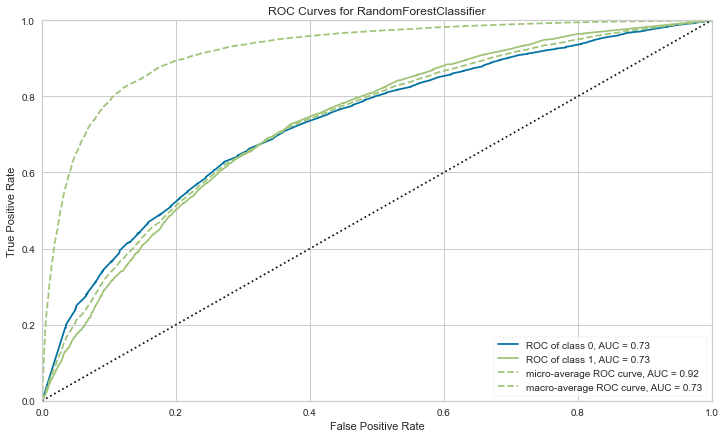

In [87]:
plot_model(final_model, plot = 'auc')

### Confusion Matrix
Despite of the promising result in the __AUC__ plot, the __Confusion Matrix__ reveals that capability of spotting buying event is troublesome

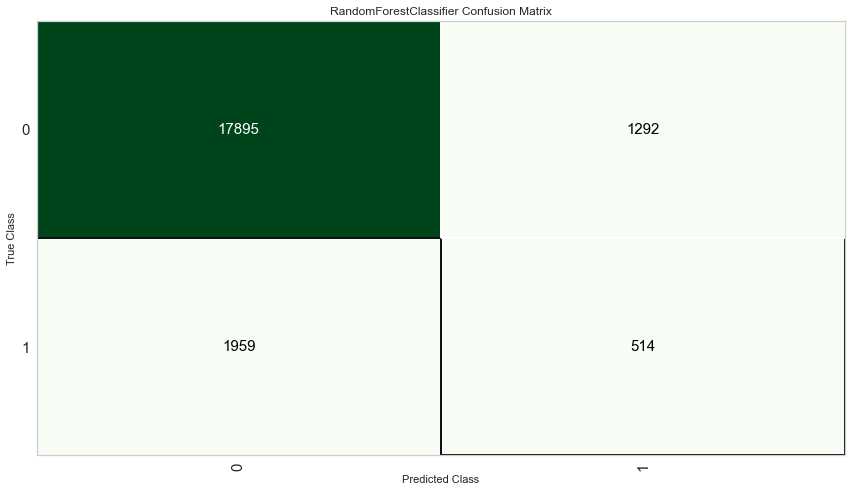

In [88]:
plot_model(final_model, plot = 'confusion_matrix')